# Project 3: Classify Song Lyrics according to Genre
Authors: 
* Andreas Bonny
* Niclas Lensch
* Klaus Luhan

## Goal
The goal of this project is to find out whether it is possible to predict the genre of a song based on its lyrics. To
this end, devise one or multiple approaches based on the methods discussed in the lecture and evaluate how
well they perform.


# Prerequisite

## Download nltk

This work makes heavy use of the nltk-framework, the download can be startet with: '#nltk.download()'

In [107]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Checking for GPU

*This section can be ignored if there is no valid GPU set up*

For better performance we recommend the usage of GPU and CPU, if there is a GPU available but not set up, we recommend adding it to your python-environment.

In [108]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print("There is", len(gpus), "detected GPU")
print("There is", len(cpus), "detected CPU")

There is 1 detected GPU
There is 1 detected CPU


In addition we recommend enabling memory growth

In [109]:
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Prepare Data for preprocessing
Before we can begin with our neural networks, we first have to preprocess it. However, even we must first prepare our data for the preprocessing. 

## Load form Disk and join

We load the required data into to a pandas dataframe and join them by a common field.
For convenient use, we transform all identifiers to lower case.

In [110]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

There are 227513 datasets loaded


## Remove unneeded data

Now that our ~227000 datasets are loaded, we can remove further unwanted information.
As we only want to categorize English lyrics, we remove all rows that have another Idiom set. 
We also removed duplicates in order to get a clear dataset.

In [111]:
import pandas as pd

columns_to_drop = ['sname','slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom']

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(columns_to_drop, axis=1)

# General preprocessing

After our data is loaded and all unnecessary columns are dropped, we can further process our lyrics. For easier processing, all lyrics are converted to lowercase before they are tokenized, lemmatized and cleaned.

In [112]:
import pandas as pd

transformed_df = filterd_df

## Lowercase

In [113]:
import pandas as pd

transformed_df['lyric'] = transformed_df['lyric'].str.lower()

## Tokenize
During the tokenization of our lyrics, we also remove stopwords. We used gensim in order to gain a preexisting list while also adding a few other stopwords. As a result of this step, we gain am object, that contains the lyrics without the found stopwords in word-level-tokens.

In [114]:
import nltk
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords

def lyric_to_verse(lyric):
    return nltk.sent_tokenize(lyric,language='english')

def verse_to_word(verse):
    customStopwords = ["'s'", "n't", "aint", "oh", "im", "yeah", "youre", "cant", "dont", "em", "you'll", "it's", "hey"]
    all_stopwords = STOPWORDS.union(set(customStopwords))
    
    verse = remove_stopwords(verse)
    return nltk.word_tokenize(verse, language='english')

print("Pre: ", transformed_df['lyric'])
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lyric_to_verse(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: [verse_to_word(verse) for verse in x])
print("Post: ", transformed_df['lyric'])

Pre:  0         i could feel at the time. there was no way of ...
2         take me now, baby, here as i am. hold me close...
4         these are. these are days you'll remember. nev...
6         a lie to say, "o my mountain has coal veins an...
8         trudging slowly over wet sand. back to the ben...
                                ...                        
225903    (chorus). hello, hello,hello,how low. hello,he...
225929    well sometimes i go out by myself. and i look ...
225937    feeling my way through the darkness. guided by...
226103    don't, don't, that's what you say. each time t...
227276    i've been. for almost everything in life. in t...
Name: lyric, Length: 87151, dtype: object
Post:  0         [[feel, time, .], [way, knowing, .], [fallen, ...
2         [[now, ,, baby, ,, am, .], [hold, close, ,, tr...
4         [[are, .], [days, you, 'll, remember, .], [sin...
6         [[lie, say, ,, ``, o, mountain, coal, veins, b...
8         [[trudging, slowly, wet, sand, .], 

## Lemmatize


In [115]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

We remove any artifacts that survived the lemmatization such as empty words, single letter words and all non alphabetic characters

In [116]:
import re

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 

# Store preproccesed data
In further steps, we directly want to access the processed data, without needing to preprocess the data with each execution. We save a new file that contains the processed data.

## Save to disk

In [117]:
transformed_df.to_csv (r'./export_dataframe.csv', index = False, header=True)

# Optional preprocessing

In this step we flatten our data.

BUG: wenn man es das erste mal ausfrührt muss man eine zeile im helper auskommentieren die probiert die später erstellte datei zu erstellen, rennen hier etwas in ein henne ei problem

In [118]:
from helper import get_fresh_flatted_copy

transformed_opt_df = get_fresh_flatted_copy(1)

## Remove lyrics that are too long
We checked, whether or not removing songs that are too long increases our accuracy. However, it was not possible to properly separate long lyrics from "regular" lyrics. As such, this step did not bear great results.

In [119]:
import pandas as pd

def identifyLongLyrics(data_df, capsize = 1500):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size <= ' + str(capsize))
    return data_df
    
    
def identifyShortLyrics(data_df, minSize = 10):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size >= ' + str(minSize))
    return data_df

transformed_opt_df = identifyLongLyrics(transformed_opt_df)
transformed_opt_df = identifyShortLyrics(transformed_opt_df)

## Remove additional genres

While analyizing our data, we observed that after removing all non-english songs, there are genres that contain almost no songs and therefore are unnecessary for the predictions. Thus, we removed all genres that contain less songs than a given threshhold (default value was 100)

In [120]:
import pandas as pd

def filterSmallGenres(data, level='lyric',threshold = 100):
    genres = data.genre.unique()

    df_container = {}

    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    for key in list(df_container.keys()):
        if(len(df_container[key]) < threshold):
            del df_container[key]

    return pd.concat(df_container.values())

transformed_opt_df = filterSmallGenres(transformed_opt_df)

## Normalize dataset

Normilization is a common way of preprocessing data and therefore is also used here.

In [121]:
def normalizeData(data, level='lyric'):
    genres = data.genre.unique()

    df_container = {}

    #Baue einen dict anhand der existierenden genres
    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    sampleSize = 0
    
    #Finde heraus welches genre die wenigsten lieder enthält
    for key in list(df_container.keys()):
        if(sampleSize == 0):
            sampleSize = len(df_container[key])
        else:
            if(len(df_container[key]) < sampleSize):
                sampleSize = len(df_container[key])
            
    #Pick mir einen Sample anhand des wertes sampleSize
    for key in list(df_container.keys()):
        df_container[key] = df_container[key].sample(n = sampleSize);
    
    return pd.concat(df_container.values())
    
transformed_opt_df = normalizeData(transformed_opt_df)

# Store optional preprocessed data

The optionally preprocessed data is again saved in another file for easier access. In the following steps, there is always the option to either use the general preprocessed data or to use the optional data.

In [122]:
transformed_opt_df.to_csv (r'./export_dataframe_opt.csv', index = False, header=True)

# Look at the data
Before we use neural networks and machine learning algorithms zu analyze our data, we want to give a general overview of our now preprocessed data. We take a look at the genre and frequency distribution of our data as well as other information.

## Genre distribution

First we will look at the distribution of generes in our dataset

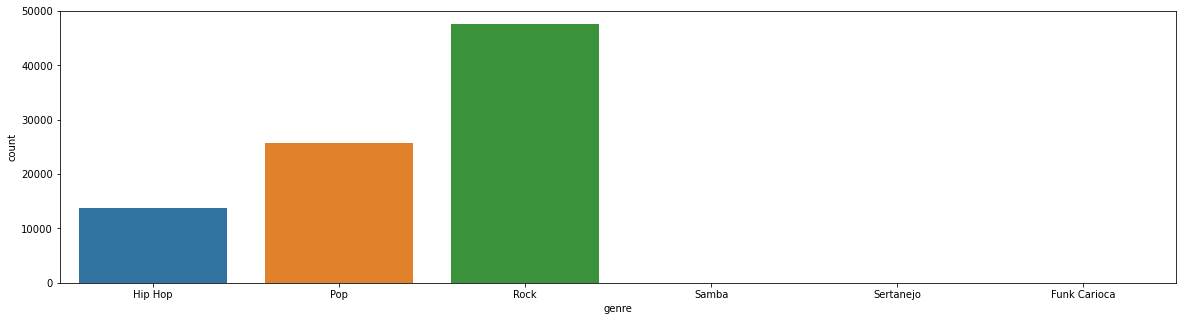

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from helper import get_fresh_copy

plt.figure(figsize=(20, 5))
sns.countplot(data=get_fresh_copy(), x='genre')

## Frequency distribution

We also want to display a frequency distribution of the most common words in our dataset. We also take a look at the distribution of stopwords of different genres

In [4]:
import itertools
import nltk
import pandas as pd

def lengthDistribution(data_df):
    genres = data_df.genre.unique()

    lengthDistribution
    df_container = {}
    fd_container = {}

    total_word_count = {}

    merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(data_df['lyric'])).items(), columns=['words', 'frequency'])
    merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

    for genre in genres:
        df_container[genre] = data_df[data_df.genre.eq(genre)]
        fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
        total_word_count[genre] = sum(fd_container[genre].values())
        fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
        fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
        merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
    merged_fd_df = merged_fd_df.set_index('words')
    
    return merged_fd_df

### General preprocessed dataset

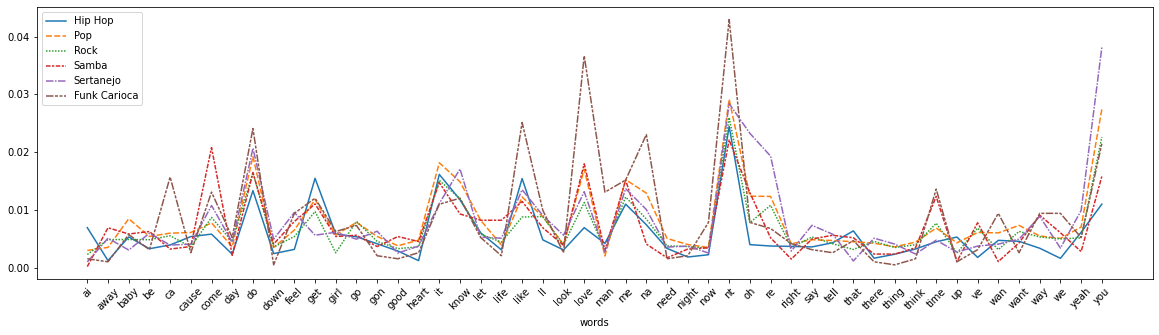

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_flatted_copy

        
length_distribution_df = lengthDistribution(get_fresh_flatted_copy(1))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

### Optional preprocessed dataset

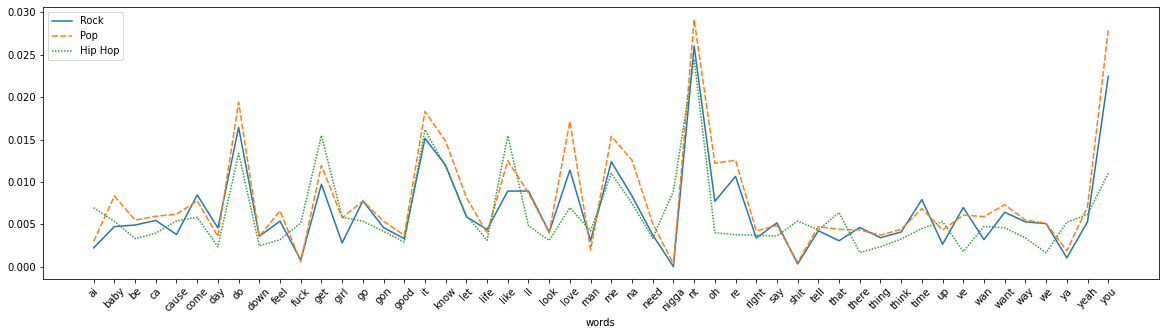

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_copy

        
length_distribution_df = lengthDistribution(get_fresh_copy(opt=True))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

## Distribution of lyric length by genre (word based)

We take a look whether some genres are more likely to have longer lyrics than others.

In [6]:
import pickle

def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

### General preprocessed dataset

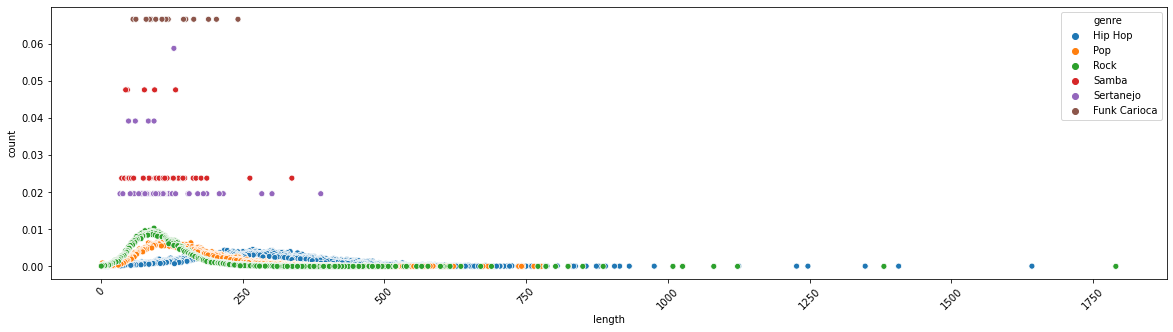

In [7]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

### Optional preprocessed dataset
If we take a look at only our three main genres, Rock, Pop and Hip Hop, we see, that generally Rock songs are the shortest of all of them. Most Rock songs are less than 200 words long (after removing stopwords) while Hip Hop contains the longest songs, some of which contain more than 600 words.

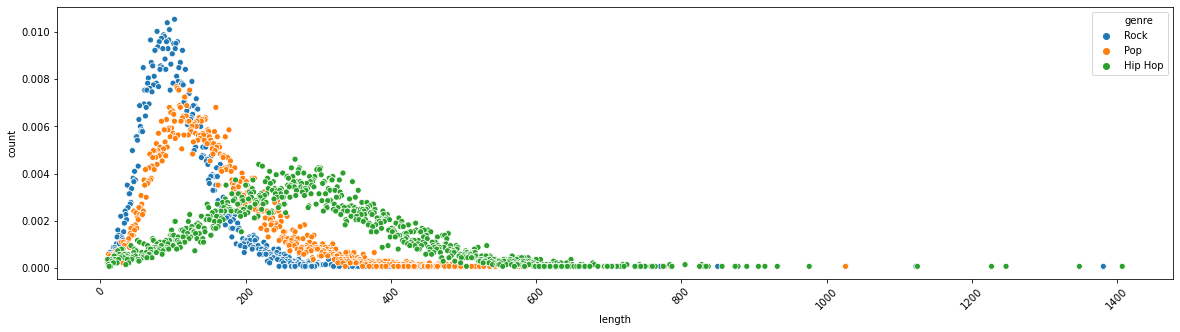

In [8]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_copy(opt=True)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

## Distribution of lyric length by genre (verse based)

We take another look at the distibution of lyric length, this time, the length is based on a whole verse instead of words. Our result is that most songs consist of less than 8 verses while Hip Hop lyrics are generally longer than other genres which confirms the word based distribution in which Hip Hop also is generally longer than Rock or Pop. 

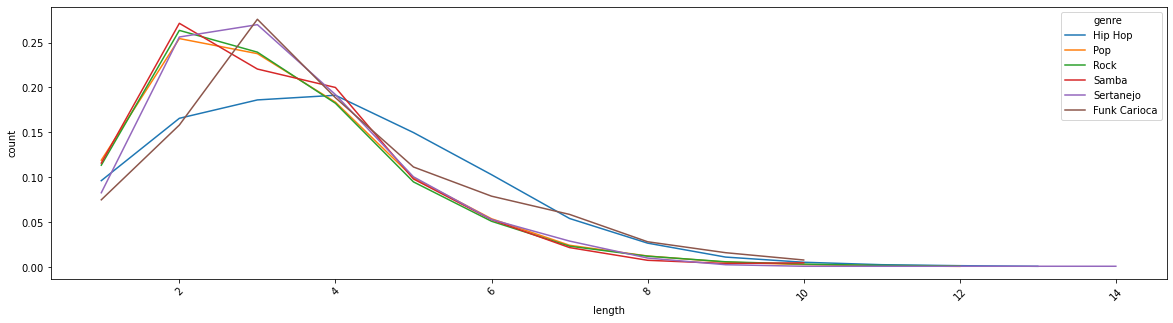

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy, melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Distribution of lyric length by genre (lyrics/verse based)

we look if some generes as more likly to have shorter or longer lyrics

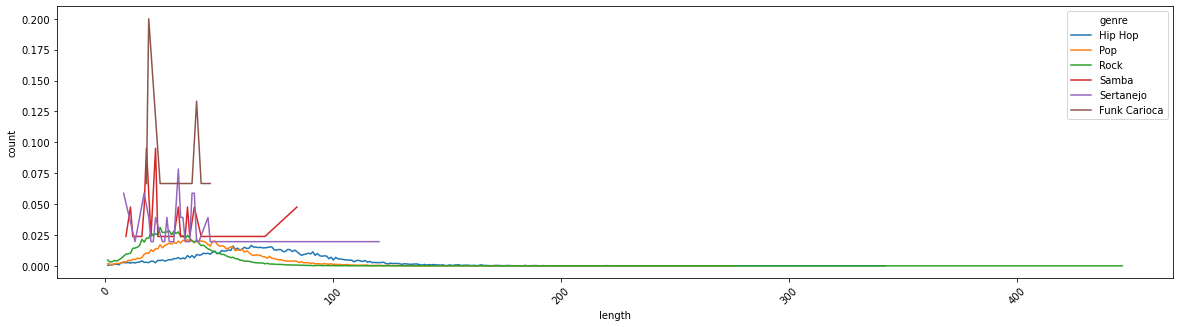

In [10]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df, x="length", y="count", hue="genre")

In [ ]:
#todo nachschauen wieviele wörter wie oft auftauchen
#wäre cool wenn wir das noch hinbekommen aber das formulieren der texte ist viel wichtiger

# Learning

## Simple Neural Networks

In [6]:
# Move to Helper
#https://stackoverflow.com/questions/42406233/how-to-add-title-to-seaborn-boxplot
def print_graph(history_a, history_b):
    history_df = pd.DataFrame(history_a.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title('General Data')

    history_df = pd.DataFrame(history_b.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title("Optional Data")

### Prepare Data

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
    tokenizer = Tokenizer(num_words=10000)

    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    tokenizer.fit_on_texts(x_train)

    x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

g_x_train, g_x_test, g_y_train, g_y_test, g_num_classes = prepData(get_fresh_flatted_copy())
o_x_train, o_x_test, o_y_train, o_y_test, o_num_classes = prepData(get_fresh_copy(opt=1))

Using TensorFlow backend.


## Baselines

In [3]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=10)
dummy.fit(g_x_train, g_y_train)
most_frequent_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always choosing the most frequent label: ", most_frequent_score) # always predicts most frequent label

dummy = DummyClassifier(strategy="uniform", random_state=10)
dummy.fit(g_x_train, g_y_train)
uniform_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always predicting label at random: ", uniform_score) # random prediction

dummy = DummyClassifier(strategy="stratified", random_state=10, constant="rock")
dummy.fit(g_x_train, g_y_train)
stratified_score = dummy.score(g_x_test, g_y_test)
print("Baseline by respecting the training sets class distribution: ", stratified_score) # prediction by respecting the training sets class distribution

NameError: name 'g_x_train' is not defined

### Shallow Neural Network

#### General Data

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict = history_g.history
acc_g = history_g_dict['accuracy']
vacc_g = history_g_dict['val_accuracy']
loss_g = history_g_dict['loss']
vloss_g = history_g_dict['val_loss']


score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Train on 62748 samples, validate on 6972 samples
Epoch 1/5
62748/62748 [==============================] - 12s 191us/step - loss: 0.6840 - accuracy: 0.7151 - val_loss: 0.6051 - val_accuracy: 0.7483
Epoch 2/5
62748/62748 [==============================] - 12s 190us/step - loss: 0.5432 - accuracy: 0.7739 - val_loss: 0.5974 - val_accuracy: 0.7543
Epoch 3/5
62748/62748 [==============================] - 12s 190us/step - loss: 0.4767 - accuracy: 0.8029 - val_loss: 0.6202 - val_accuracy: 0.7483
Epoch 4/5
62748/62748 [==============================] - 12s 190us/step - loss: 0.4245 - accuracy: 0.8262 - val_loss: 0.6629 - val_accuracy: 0.7499
Epoch 5/5
17431/17431 [==============================] - 3s 157us/step


#### Optional Data

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict = history_o.history
acc_o = history_o_dict['accuracy']
vacc_o = history_o_dict['val_accuracy']
loss_o = history_o_dict['loss']
vloss_o = history_o_dict['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7020 - accuracy: 0.6836 - val_loss: 0.6143 - val_accuracy: 0.7272
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5269 - accuracy: 0.7754 - val_loss: 0.6207 - val_accuracy: 0.7358
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.4277 - accuracy: 0.8204 - val_loss: 0.6648 - val_accuracy: 0.7306
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.3655 - accuracy: 0.8494 - val_loss: 0.7179 - val_accuracy: 0.7220
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.8084 - accuracy: 0.7182


#### Results

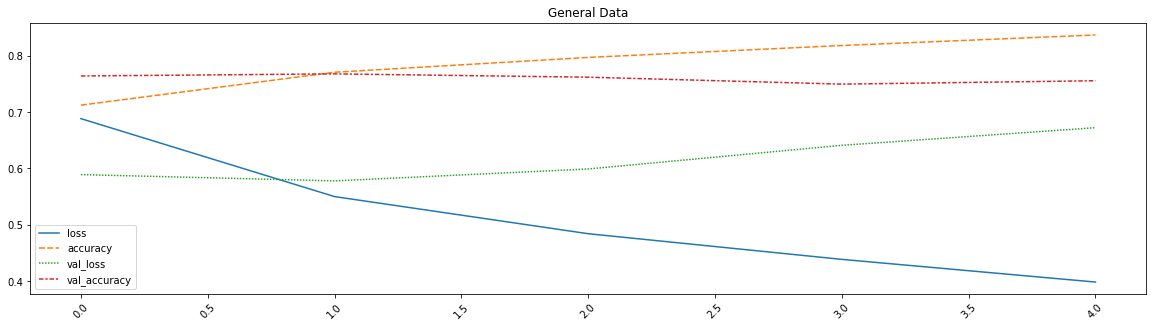

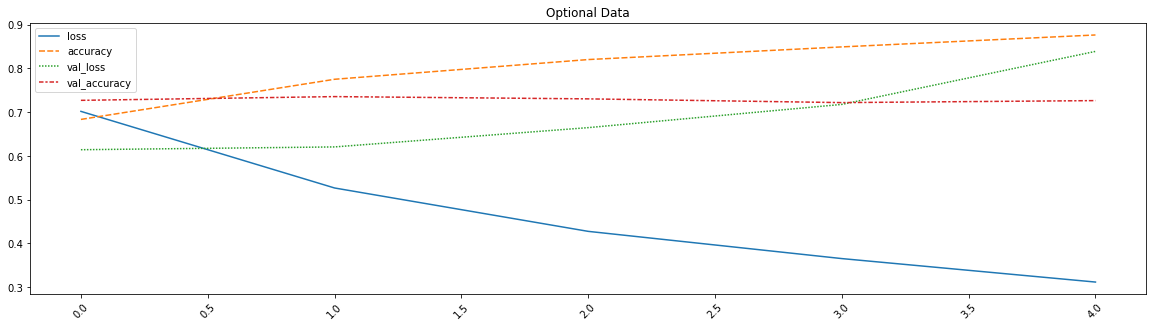

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Deep Dense Neural Network

#### General Data

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_deep = history_g.history
acc_g_deep = history_g_dict_deep['accuracy']
vacc_g_deep = history_g_dict_deep['val_accuracy']
loss_g_deep = history_g_dict_deep['loss']
vloss_g_deep = history_g_dict_deep['val_loss']

score_g_deep = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Train on 62748 samples, validate on 6972 samples
Epoch 1/5
62748/62748 [==============================] - 15s 232us/step - loss: 0.7342 - accuracy: 0.6814 - val_loss: 0.6618 - val_accuracy: 0.6955
Epoch 2/5
62748/62748 [==============================] - 15s 241us/step - loss: 0.6094 - accuracy: 0.7441 - val_loss: 0.6084 - val_accuracy: 0.7421
Epoch 3/5
62748/62748 [==============================] - 14s 229us/step - loss: 0.5534 - accuracy: 0.7750 - val_loss: 0.6075 - val_accuracy: 0.7405
Epoch 4/5
62748/62748 [==============================] - 15s 241us/step - loss: 0.5027 - accuracy: 0.7971 - val_loss: 0.6117 - val_accuracy: 0.7348
Epoch 5/5
62748/62748 [==============================] - 15s 235us/step - loss: 0.4629 - accuracy: 0.8191 - val_loss: 0.6308 - val_accuracy: 0.7435


AttributeError: 'dict' object has no attribute 'evaluate'

#### Optional Data

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_deep = history_o.history
acc_o_deep = history_o_dict_deep['accuracy']
vacc_o_deep = history_o_dict_deep['val_accuracy']
loss_o_deep = history__dict_deep['loss']
vloss_o_deep = history_o_dict_deep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7853 - accuracy: 0.6032 - val_loss: 0.7205 - val_accuracy: 0.6489
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.6673 - accuracy: 0.6915 - val_loss: 0.7018 - val_accuracy: 0.6599
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5992 - accuracy: 0.7378 - val_loss: 0.6548 - val_accuracy: 0.6986
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5334 - accuracy: 0.7722 - val_loss: 0.6583 - val_accuracy: 0.7126
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.7053


#### Results

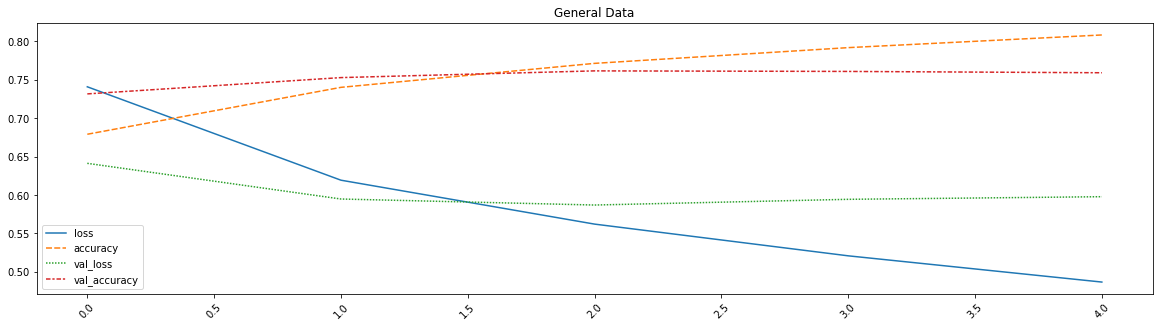

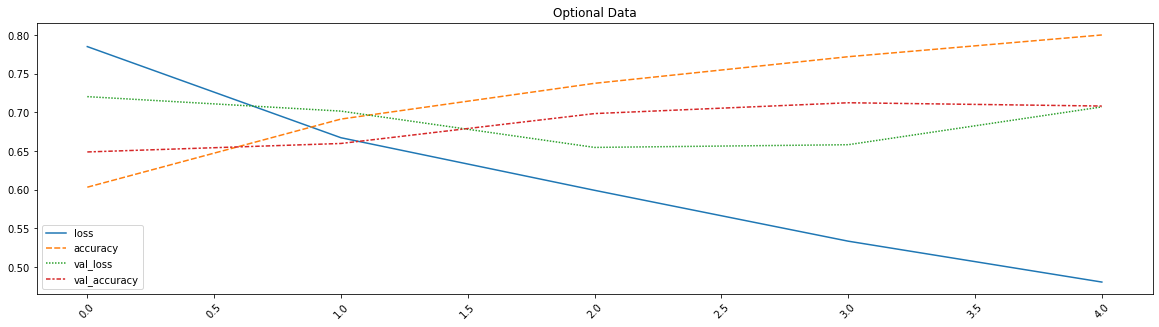

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Big Deep Dense Neural Network

#### General Data

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_bigdeep = history_g.history
acc_g_bigdeep = history_g_dict_bigdeep['accuracy']
vacc_g_bigdeep = history_g_dict_bigdeep['val_accuracy']
loss_g_bigdeep = history_g_dict_bigdeep['loss']
vloss_g_bigdeep = history_g_dict_bigdeep['val_loss']

score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 31s 16ms/step - loss: 0.7913 - accuracy: 0.6884 - val_loss: 0.6470 - val_accuracy: 0.7579
Epoch 2/5
1961/1961 [==============================] - 26s 13ms/step - loss: 0.7081 - accuracy: 0.7307 - val_loss: 0.6553 - val_accuracy: 0.7216
Epoch 3/5
1961/1961 [==============================] - 25s 13ms/step - loss: 0.6492 - accuracy: 0.7576 - val_loss: 0.7156 - val_accuracy: 0.7147
Epoch 4/5
1961/1961 [==============================] - 26s 13ms/step - loss: 0.7955 - accuracy: 0.7013 - val_loss: 0.9633 - val_accuracy: 0.6406
Epoch 5/5
545/545 [==============================] - 1s 3ms/step - loss: 1.0299 - accuracy: 0.6459


#### Optional Data

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_bigdeep = history_o.history
acc_o_bigdeep = history_o_dict_bigdeep['accuracy']
vacc_o_bigdeep = history_o_dict_bigdeep['val_accuracy']
loss_o_bigdeep = history_o_dict_bigdeep['loss']
vloss_o_bigdeep = history_o_dict_bigdeep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 15s 16ms/step - loss: 0.8664 - accuracy: 0.6537 - val_loss: 0.6798 - val_accuracy: 0.7248
Epoch 2/5
923/923 [==============================] - 12s 13ms/step - loss: 0.6092 - accuracy: 0.7524 - val_loss: 0.7336 - val_accuracy: 0.6699
Epoch 3/5
923/923 [==============================] - 11s 12ms/step - loss: 0.5198 - accuracy: 0.8190 - val_loss: 0.9134 - val_accuracy: 0.7226
Epoch 4/5
923/923 [==============================] - 13s 14ms/step - loss: 0.3977 - accuracy: 0.8693 - val_loss: 1.0429 - val_accuracy: 0.7092
Epoch 5/5
257/257 [==============================] - 1s 3ms/step - loss: 1.2729 - accuracy: 0.7009


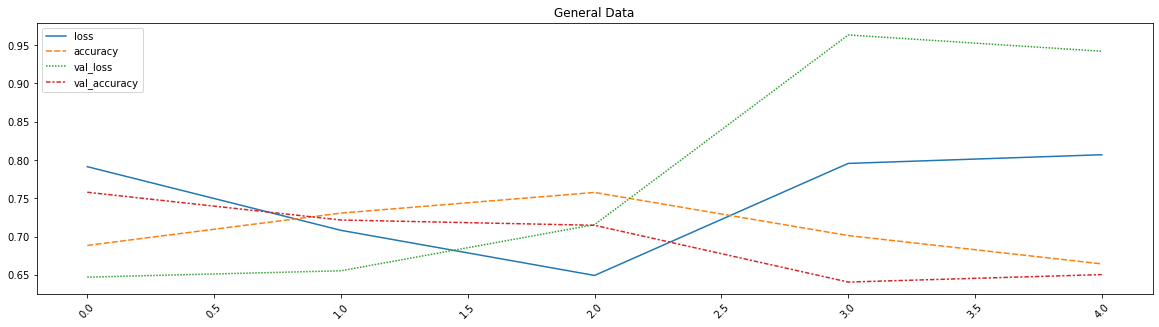

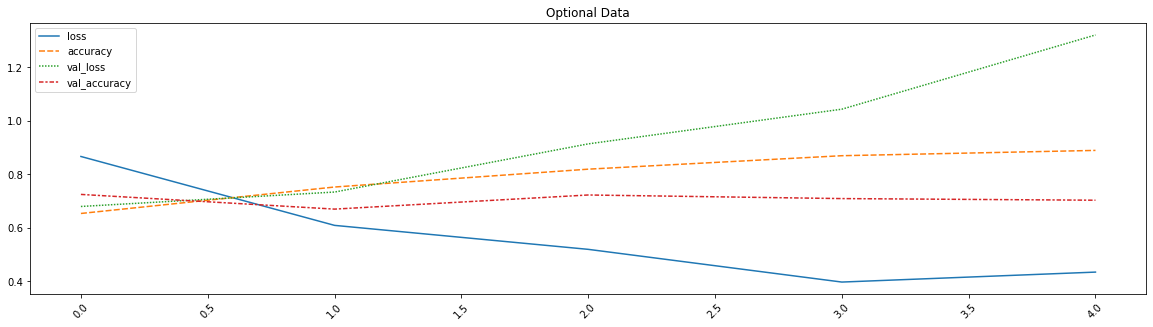

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

## Complex Neural Networks

In [2]:
MAX_SEQUENCE_LENGTH = 400
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Prepare Data

load data and factorize 'genre'

#### Load Data

In [5]:
import pandas as pd
from helper import melt, get_fresh_flatted_copy

preprocessed_df = pd.DataFrame(get_fresh_flatted_copy(1))

#https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
preprocessed_df.genre = pd.factorize(preprocessed_df.genre)[0]

In [6]:
display(preprocessed_df)

,lyric,artist,genre
51949,"[intro, akon, chamillionaire, see, remember, b...",Chamillionaire,0
64994,"[wyclef, jean, feat, canibus, kelly, khadejiah...",Wyclef Jean,0
51740,"[bun, talk, man, fo, real, love, be, from, the...",Bun-b,0
20431,"[be, weak, and, powerless, taste, oh, so, well...",Kerli,1
42178,"[sometimes, do, nt, know, what, to, think, abo...",The Flaming Lips,2
...,...,...,...
21440,"[my, mama, say, that, your, life, be, gift, an...",Lenny Kravitz,2
73349,"[not, sayin, nothin, you, do, nt, already, kno...",Gwen Stefani,1
50057,"[people, gon, talk, that, what, they, do, when...",50 Cent,0
5192,"[wan, na, drag, you, around, wan, na, drag, yo...",Blondie,2


save needed dataframes as arrays and hot-encode the label

In [7]:
import numpy as np
from keras.utils import to_categorical

labels_index = preprocessed_df['genre'].unique()
texts = np.asarray(preprocessed_df['lyric'])
labels = np.asarray(preprocessed_df['genre'])

labels = to_categorical(np.asarray(labels))

convert lyrics to verctors and pad the result

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


#### Split Data
split the data into a training set and a validation set

In [9]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#### Build embedding layer

#### pre-trained embedding

load the pre-trained glove-model

In [10]:
from helper import loadGloveModel

embeddings_index = loadGloveModel()

build the embedding-matrix 

In [11]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

build the embedding-lyer

In [12]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### not pre-trained embedding

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

### Convolutional Neural Network with MaxPooling

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

innter_layer = Conv1D(128, 5, activation='relu')(embedded_sequences)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = GlobalMaxPooling1D()(innter_layer)
innter_layer = Dense(64, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(32, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(16, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)

output_1 = Dense(len(labels_index), activation='softmax')(innter_layer)

model = Model(sequence_input, output_1)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_convolutionalPooling = history.history
acc_convolutionalPooling = history_dict_convolutionalPooling['acc']
vacc_convolutionalPooling = history_dict_convolutionalPooling['val_acc']
loss_convolutionalPooling = history_dict_convolutionalPooling['loss']
vloss_convolutionalPooling = history_dict_convolutionalPooling['val_loss']

Epoch 1/20
545/545 [==============================] - 9s 16ms/step - loss: 1.0290 - acc: 0.5642 - val_loss: 0.7333 - val_acc: 0.6699
Epoch 2/20
545/545 [==============================] - 8s 16ms/step - loss: 0.7824 - acc: 0.6582 - val_loss: 0.7005 - val_acc: 0.6848
Epoch 3/20
545/545 [==============================] - 9s 16ms/step - loss: 0.7423 - acc: 0.6759 - val_loss: 0.7095 - val_acc: 0.6994
Epoch 4/20
545/545 [==============================] - 8s 16ms/step - loss: 0.7159 - acc: 0.6872 - val_loss: 0.6950 - val_acc: 0.7024
Epoch 5/20
545/545 [==============================] - 9s 16ms/step - loss: 0.6971 - acc: 0.6933 - val_loss: 0.7091 - val_acc: 0.7054
Epoch 6/20
545/545 [==============================] - 8s 16ms/step - loss: 0.6893 - acc: 0.6967 - val_loss: 0.7369 - val_acc: 0.7073
Epoch 7/20
545/545 [==============================] - 9s 16ms/step - loss: 0.6787 - acc: 0.7029 - val_loss: 0.8135 - val_acc: 0.7082
Epoch 8/20
545/545 [==============================] - 9s 16ms/step - 

<AxesSubplot:>

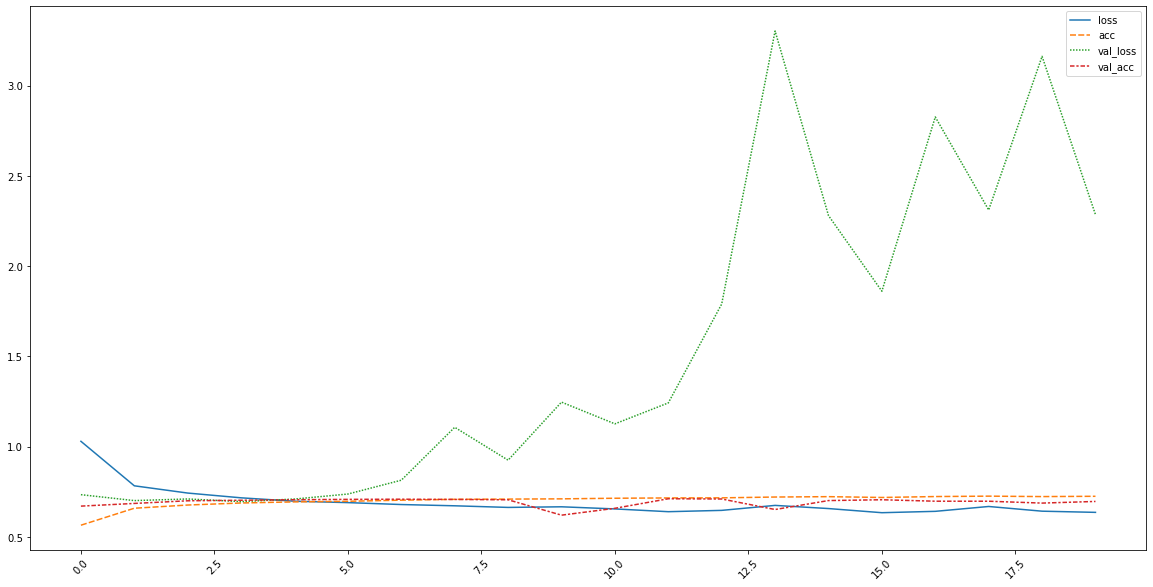

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

### Recurrent Bidirectional Neural Network

In [18]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential


model = Sequential()
model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Dropout(0.1))
model.add(Bidirectional(GRU(16, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8)))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_recurrentBidirectional = history.history
acc_recurrentBidirectional = history_dict_recurrentBidirectional['acc']
vacc_recurrentBidirectional = history_dict_recurrentBidirectional['val_acc']
loss_recurrentBidirectional = history_dict_recurrentBidirectional['loss']
vloss_recurrentBidirectional = history_dict_recurrentBidirectional['val_loss']

Epoch 1/20
2179/2179 [==============================] - 91s 42ms/step - loss: 0.8646 - acc: 0.6258 - val_loss: 0.7292 - val_acc: 0.6788
Epoch 2/20
2179/2179 [==============================] - 95s 43ms/step - loss: 0.7396 - acc: 0.6790 - val_loss: 0.6763 - val_acc: 0.7026
Epoch 3/20
2179/2179 [==============================] - 95s 44ms/step - loss: 0.7082 - acc: 0.6978 - val_loss: 0.6626 - val_acc: 0.7151
Epoch 4/20
2179/2179 [==============================] - 94s 43ms/step - loss: 0.6891 - acc: 0.7082 - val_loss: 0.6974 - val_acc: 0.6900
Epoch 5/20
2179/2179 [==============================] - 94s 43ms/step - loss: 0.6723 - acc: 0.7174 - val_loss: 0.6458 - val_acc: 0.7181
Epoch 6/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6593 - acc: 0.7224 - val_loss: 0.6271 - val_acc: 0.7342
Epoch 7/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6506 - acc: 0.7270 - val_loss: 0.6283 - val_acc: 0.7343
Epoch 8/20
2179/2179 [==========================

<AxesSubplot:>

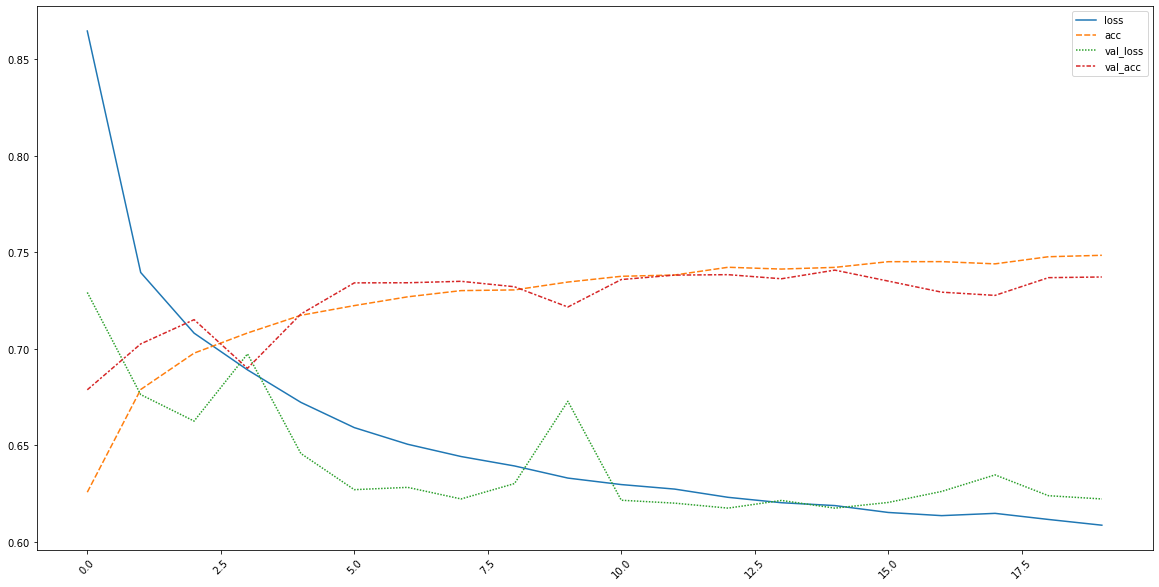

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

# Classic Machine Learning

In [151]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(list(preprocessed_df['lyric']), list(preprocessed_df['genre']), test_size=0.80)
    #tokenizer = Tokenizer(num_words=10000)

    #le = preprocessing.LabelEncoder()
    #le.fit(y_train)
    #y_train = le.transform(y_train)
    #y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    #tokenizer.fit_on_texts(x_train)

    #x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    #x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    #y_train = keras.utils.to_categorical(y_train)
    #y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

def joinSong(songs):
    result = []
    for i in songs:
        delimiter = " "
        delimiter = delimiter.join(i)
        result.append(delimiter)
    return result

x_train, x_test, y_train, y_test, num_classes = prepData(get_fresh_flatted_copy(1))

x_train = joinSong(x_train)
x_test = joinSong(x_test)


le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)

In [152]:
#https://pythonhealthcare.org/2018/12/15/104-using-free-text-for-classification-bag-of-words/
def create_bag_of_words(x):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 ngram_range = (1,2), \
                                 max_features = 10000
                                ) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings. The output is a sparse array
    
    train_data_features = vectorizer.fit_transform(x)
    
    # Convert to a NumPy array for easy of handling
    train_data_features = train_data_features.toarray()
    
    # tfidf transform
    from sklearn.feature_extraction.text import TfidfTransformer
    
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()

    # Get words in the vocabulary
    vocab = vectorizer.get_feature_names()
   
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [153]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  = create_bag_of_words(x_train)

In [154]:
import pandas as pd

bag_dictionary = pd.DataFrame()
bag_dictionary['ngram'] = vocab
bag_dictionary['count'] = train_data_features[0]
bag_dictionary['tfidf_features'] = tfidf_features[0]

# Sort by raw count
bag_dictionary.sort_values(by=['count'], ascending=False, inplace=True)
# Show top 10
display(bag_dictionary.head(10))

,ngram,count,tfidf_features
4913,more,15,0.346782
9905,your,12,0.158547
3643,it,11,0.120003
3490,if,10,0.172588
7602,than,9,0.246410
695,be,9,0.087347
4921,more than,8,0.308417
7605,than it,6,0.376718
3662,it be,6,0.157219
3736,it more,5,0.284048


In [155]:
def train_logistic_regression(features, label):
    print ("Training the logistic regression model...")
    from sklearn.linear_model import LogisticRegression
    ml_model = LogisticRegression(C = 100,random_state = 0, max_iter=1000)
    ml_model.fit(features, label)
    print ('Finished')
    return ml_model

In [156]:
# wenn datensatz klein ist muss man max_iter hochstellen damit es convergiert
ml_model = train_logistic_regression(tfidf_features, y_train)

Training the logistic regression model...
Finished


In [157]:
test_data_features = vectorizer.transform(x_test)
# Convert to numpy array
test_data_features = test_data_features.toarray()

In [158]:
test_data_tfidf_features = tfidf.fit_transform(test_data_features)
# Convert to numpy array
test_data_tfidf_features = test_data_tfidf_features.toarray()

In [150]:
import numpy as np

predicted_y = ml_model.predict(test_data_tfidf_features)
correctly_identified_y = predicted_y == y_test
accuracy = np.mean(correctly_identified_y) * 100
print ('Accuracy = %.0f%%' %accuracy)

Accuracy = 66%


# Summery

## Base line

* baselines berechnen 
* Loss or Accuracy

## Comparing results

## Restriction